In [ ]:
# ad_forecasting_all_models.py

import pandas as pd
import numpy as np
import random
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
import seaborn as sns

# ── scikit-learn for RandomForest & XGBoost tabular pipelines
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# XGBoost
from xgboost import XGBRegressor

# TensorFlow/Keras for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def generate_data(n=10000):
    platforms = ['Facebook', 'Instagram']
    ad_types = ['Image', 'Video', 'Carousel','SlideShow','Collection']
    ages = ['18-25', '26-35', '18-30','14-18','35-50']
    genders = ['Male', 'Female', 'All']
    start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')

    data = []
    for i in range(n):
        date = start_date + timedelta(days=random.randint(0, 60))
        platform = random.choice(platforms)
        budget = random.randint(100, 1000)
        ad_type = random.choice(ad_types)
        age = random.choice(ages)
        gender = random.choice(genders)
        impressions = int(budget * random.uniform(15, 30))
        clicks = int(impressions * random.uniform(0.05, 0.15))
        conversions = int(clicks * random.uniform(0.05, 0.1))
        data.append([1000+i, platform, date, budget, ad_type, age, gender, impressions, clicks, conversions])

    df = pd.DataFrame(data, columns=[
        'Ad_ID', 'Platform', 'Date', 'Budget', 'Ad_Type',
        'Target_Age', 'Target_Gender', 'Impressions', 'Clicks', 'Conversions'
    ])
    return df

df = generate_data()

In [ ]:
df.head(5)

,Ad_ID,Platform,Date,Budget,Ad_Type,Target_Age,Target_Gender,Impressions,Clicks,Conversions
0,1000,Instagram,2024-03-01,980,Carousel,14-18,Male,14856,1421,131
1,1001,Instagram,2024-02-22,136,Image,18-30,Female,2128,226,11
2,1002,Facebook,2024-01-16,262,Collection,35-50,Male,6607,381,37
3,1003,Facebook,2024-02-05,347,SlideShow,35-50,Female,6076,340,17
4,1004,Facebook,2024-01-30,812,Video,35-50,Female,22775,1893,129


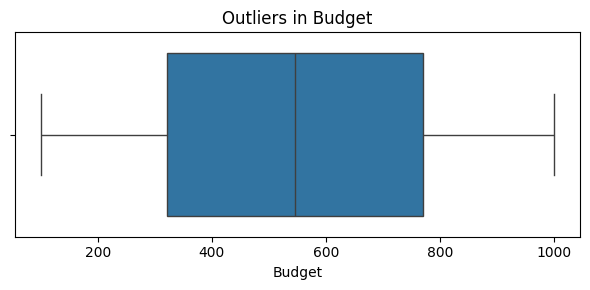

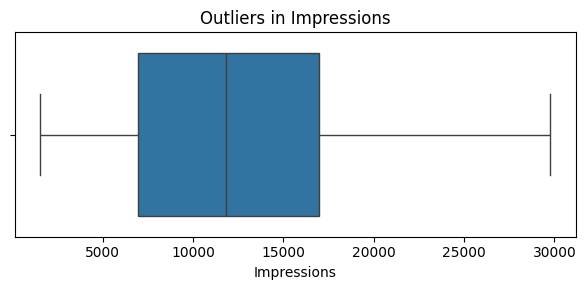

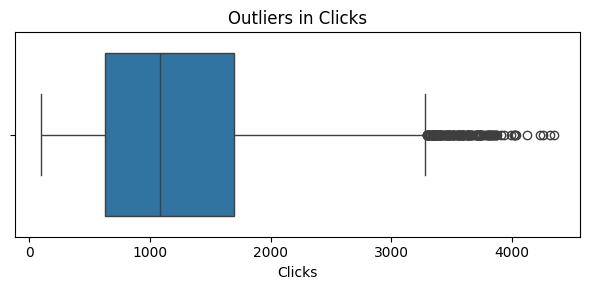

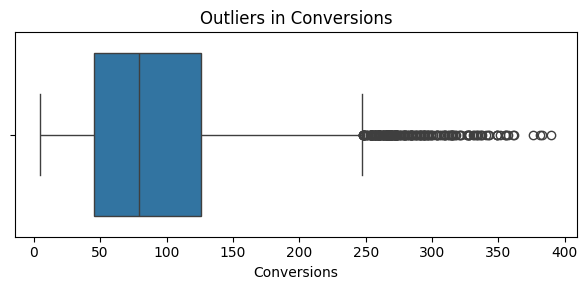

In [ ]:
# --------------------------------------
# 2. Data Preprocessing
#    a) Handle Missing Values
#    b) Outlier Analysis & Removal
#    c) Correlation Analysis
# --------------------------------------

# 2a. Missing values
df.dropna(inplace=True)

# 2b. Outlier Analysis (visual) + Removal (IQR)
numeric_cols = ['Budget', 'Impressions', 'Clicks', 'Conversions']

# Boxplots for visual inspection
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f"Outliers in {col}")
    plt.tight_layout()
    plt.show()

# IQR-based removal
def remove_outliers_iqr(dataframe, col):
    Q1 = dataframe[col].quantile(0.25)
    Q3 = dataframe[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return dataframe[(dataframe[col] >= lower) & (dataframe[col] <= upper)]

for col in numeric_cols:
    df = remove_outliers_iqr(df, col)

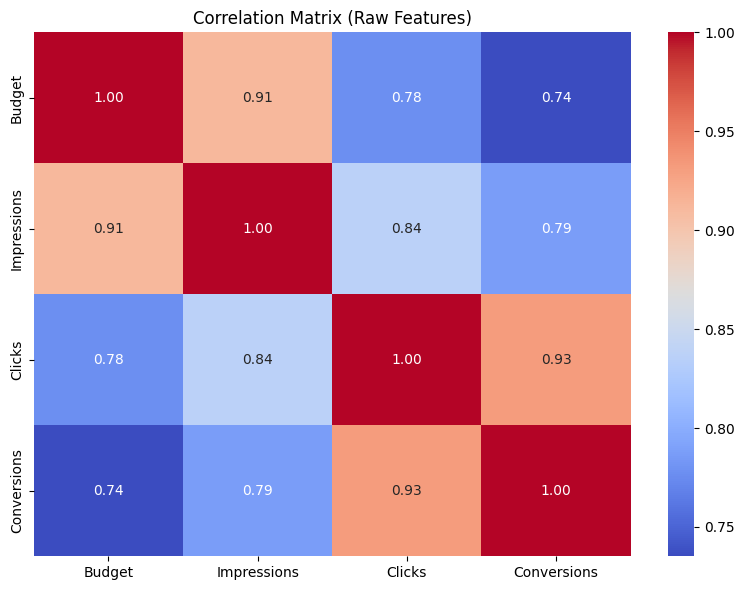

In [ ]:
# 2c. Correlation Analysis
# (Note: CTR and ConversionRate don't exist yet, so we correlate raw numbers)
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Raw Features)")
plt.tight_layout()
plt.show()

In [ ]:
# 3. Feature Engineering
#    a) CTR
#    b) ConversionRate
# --------------------------------------
df['CTR']            = df['Clicks'] / df['Impressions']
df['ConversionRate'] = df['Conversions'] / df['Clicks'].replace(0, np.nan)
df['ConversionRate'].fillna(0, inplace=True)

# --------------------------------------
# 4. Preprocessing Pipeline
# --------------------------------------
features             = ['Platform', 'Budget', 'Ad_Type', 'Target_Age', 'Target_Gender']
categorical_features = ['Platform', 'Ad_Type', 'Target_Age', 'Target_Gender']
numerical_features   = ['Budget']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

<ipython-input-6-468f805561e7>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ConversionRate'].fillna(0, inplace=True)


In [ ]:

# Feature Engineering: CTR & Conversion Rate
df['CTR'] = df['Clicks'] / df['Impressions']
df['ConversionRate'] = df['Conversions'] / df['Clicks'].replace(0, np.nan)
df['ConversionRate'].fillna(0, inplace=True)



<ipython-input-7-c90a5b2d1942>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ConversionRate'].fillna(0, inplace=True)


In [ ]:
# rolling 7-day averages per platform
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Platform','Date'])
for feat in ['Impressions','Clicks','Conversions']:
    df[f'{feat}_7d_avg'] = (
        df.groupby('Platform')[feat]
          .transform(lambda x: x.rolling(7, min_periods=1).mean())
    )


In [ ]:
# define features and targets
tab_features = [
    'Platform','Budget','Ad_Type','Target_Age','Target_Gender',
    'CTR','ConversionRate',
    'Impressions_7d_avg','Clicks_7d_avg','Conversions_7d_avg'
]
categorical_feats = ['Platform','Ad_Type','Target_Age','Target_Gender']
numerical_feats   = [
    'Budget','CTR','ConversionRate',
    'Impressions_7d_avg','Clicks_7d_avg','Conversions_7d_avg'
]

# preprocessing pipeline for tabular models
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_feats),
    ('num', StandardScaler(), numerical_feats)
])

In [ ]:
# split data once for all tabular models
X_tab = df[tab_features]
y_impr = df['Impressions']
y_click = df['Clicks']
y_conv = df['Conversions']

X_train, X_test, y_impr_train, y_impr_test = train_test_split(
    X_tab, y_impr, test_size=0.2, random_state=42
)
_, _, y_click_train, y_click_test = train_test_split(
    X_tab, y_click, test_size=0.2, random_state=42
)
_, _, y_conv_train, y_conv_test = train_test_split(
    X_tab, y_conv, test_size=0.2, random_state=42
)

# --------------------------------------
# 4. Train & Evaluate Tabular Models
# --------------------------------------
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost'      : XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

tab_results = {'Impressions':{}, 'Clicks':{}, 'Conversions':{}}


In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

tab_results = {'Impressions':{}, 'Clicks':{}, 'Conversions':{}}

for mname, mobj in models.items():
    pipe = Pipeline([
        ('prep', preprocessor),
        ('est',  mobj)
    ])

    # ── Impressions ──
    pipe.fit(X_train, y_impr_train)
    p_imp = pipe.predict(X_test)
    mae_imp = mean_absolute_error(y_impr_test, p_imp)
    mse_imp = mean_squared_error(y_impr_test, p_imp)
    rmse_imp = np.sqrt(mse_imp)
    tab_results['Impressions'][mname] = (mae_imp, rmse_imp)

    # ── Clicks ──
    pipe.fit(X_train, y_click_train)
    p_clk = pipe.predict(X_test)
    mae_clk = mean_absolute_error(y_click_test, p_clk)
    mse_clk = mean_squared_error(y_click_test, p_clk)
    rmse_clk = np.sqrt(mse_clk)
    tab_results['Clicks'][mname] = (mae_clk, rmse_clk)

    # ── Conversions ──
    pipe.fit(X_train, y_conv_train)
    p_conv = pipe.predict(X_test)
    mae_conv = mean_absolute_error(y_conv_test, p_conv)
    mse_conv = mean_squared_error(y_conv_test, p_conv)
    rmse_conv = np.sqrt(mse_conv)
    tab_results['Conversions'][mname] = (mae_conv, rmse_conv)


In [13]:
# --------------------------------------
# 4. LSTM Sequence Model
# --------------------------------------
ts = df.groupby('Date')[['Impressions','Clicks','Conversions']].sum().sort_index()
scaler = MinMaxScaler()
ts_scaled = pd.DataFrame(scaler.fit_transform(ts), index=ts.index, columns=ts.columns)

def make_seq(arr, window=7):
    Xs, ys = [], []
    for i in range(len(arr)-window):
        Xs.append(arr[i:i+window])
        ys.append(arr[i+window])
    return np.array(Xs), np.array(ys)

W = 7
X_seq, y_seq = make_seq(ts_scaled.values, W)
split = int(0.8*len(X_seq))
X_tr_s, X_te_s = X_seq[:split], X_seq[split:]
y_tr_s, y_te_s = y_seq[:split], y_seq[split:]

def build_lstm(shape):
    m = Sequential([
        LSTM(64, input_shape=shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(3, activation='linear')
    ])
    m.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return m

model_lstm = build_lstm((W,3))
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_lstm.fit(X_tr_s, y_tr_s, validation_split=0.2, epochs=50,
               batch_size=32, callbacks=[es], verbose=1)

y_pred_s = model_lstm.predict(X_te_s)
y_te_inv = scaler.inverse_transform(y_te_s)
y_pr_inv = scaler.inverse_transform(y_pred_s)

results_lstm = {}
for i, m in enumerate(['Impressions','Clicks','Conversions']):
    mae  = mean_absolute_error(y_te_inv[:,i], y_pr_inv[:,i])
    mse  = mean_squared_error (y_te_inv[:,i], y_pr_inv[:,i])
    rmse = np.sqrt(mse)
    results_lstm[m] = (mae, rmse)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - loss: 0.2390 - mae: 0.4442 - val_loss: 0.1540 - val_mae: 0.3590
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2186 - mae: 0.4209 - val_loss: 0.1374 - val_mae: 0.3392
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1898 - mae: 0.3850 - val_loss: 0.1198 - val_mae: 0.3183
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1631 - mae: 0.3528 - val_loss: 0.1014 - val_mae: 0.2927
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1429 - mae: 0.3239 - val_loss: 0.0844 - val_mae: 0.2651
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1182 - mae: 0.2831 - val_loss: 0.0696 - val_mae: 0.2366
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0901 - mae: 0.2404 - val_loss: 0.0571 - val_mae: 0.2082
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0760 - mae: 0.2226 - val_loss: 0.0480 - val_mae: 0.1840
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0622 - mae: 0.1960 - val_loss:

In [14]:
# 5. Comparison
# --------------------------------------
print("\n=== Model Comparison ===")
for metric in ['Impressions','Clicks','Conversions']:
    print(f"\n-- {metric} --")
    for mname, (mae, rmse) in tab_results[metric].items():
        print(f"{mname:12} MAE: {mae:.2f} | RMSE: {rmse:.2f}")
    mae, rmse = results_lstm[metric]
    print(f"{'LSTM':12} MAE: {mae:.2f} | RMSE: {rmse:.2f}")



=== Model Comparison ===

-- Impressions --
RandomForest MAE: 1982.10 | RMSE: 2556.36
XGBoost      MAE: 2070.07 | RMSE: 2684.24
LSTM         MAE: 115799.19 | RMSE: 139108.08

-- Clicks --
RandomForest MAE: 194.46 | RMSE: 259.37
XGBoost      MAE: 200.13 | RMSE: 266.98
LSTM         MAE: 12672.79 | RMSE: 15948.05

-- Conversions --
RandomForest MAE: 14.34 | RMSE: 19.15
XGBoost      MAE: 14.79 | RMSE: 19.70
LSTM         MAE: 949.55 | RMSE: 1171.00


In [17]:

import kerastuner as kt

from sklearn.model_selection import train_test_split, RandomizedSearchCV

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Platform','Date'], inplace=True)
for m in ['Impressions','Clicks','Conversions']:
    df[f'{m}_7d_avg'] = df.groupby('Platform')[m]\
                         .transform(lambda x: x.rolling(7, min_periods=1).mean())

tab_feats = [
    'Platform','Budget','Ad_Type','Target_Age','Target_Gender',
    'CTR','ConversionRate',
    'Impressions_7d_avg','Clicks_7d_avg','Conversions_7d_avg'
]
cat_feats = ['Platform','Ad_Type','Target_Age','Target_Gender']
num_feats = [
    'Budget','CTR','ConversionRate',
    'Impressions_7d_avg','Clicks_7d_avg','Conversions_7d_avg'
]

preproc_tab = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_feats),
    ('num', StandardScaler(), num_feats)
])

X = df[tab_feats]
y_imp  = df['Impressions']
y_clk  = df['Clicks']
y_conv = df['Conversions']

X_tr, X_te, y_imp_tr, y_imp_te = train_test_split(X, y_imp, test_size=0.2, random_state=42)
_,   _,   y_clk_tr, y_clk_te = train_test_split(X, y_clk, test_size=0.2, random_state=42)
_,   _,   y_conv_tr, y_conv_te = train_test_split(X, y_conv, test_size=0.2, random_state=42)

# --------------------------------------
# 4. Hyperparameter Search (RF & XGB)
# --------------------------------------
rf_params = {
    'est__n_estimators': [50,100,200],
    'est__max_depth': [None,10,20],
    'est__min_samples_split': [2,5,10]
}
xgb_params = {
    'est__n_estimators': [50,100,200],
    'est__max_depth': [3,6,9],
    'est__learning_rate': [0.01,0.1,0.2],
    'est__subsample': [0.8,1.0]
}

def tune(model, params, X_, y_):
    pipe   = Pipeline([('pre', preproc_tab), ('est', model)])
    search = RandomizedSearchCV(
        pipe, params,
        n_iter=8, cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1, random_state=42, verbose=0
    )
    search.fit(X_, y_)
    return search.best_estimator_

best = {'RF':{}, 'XGB':{}}
for name, mdl, params in [
    ('RF', RandomForestRegressor(random_state=42), rf_params),
    ('XGB', XGBRegressor(random_state=42, verbosity=0), xgb_params)
]:
    best[name]['Impressions'] = tune(mdl, params, X_tr, y_imp_tr)
    best[name]['Clicks']      = tune(mdl, params, X_tr, y_clk_tr)
    best[name]['Conversions'] = tune(mdl, params, X_tr, y_conv_tr)

# --------------------------------------
# 4a. Evaluate Tuned Tabular Models
# --------------------------------------
results_tab = {'Impressions':{}, 'Clicks':{}, 'Conversions':{}}
test_targets = {
    'Impressions': y_imp_te,
    'Clicks'     : y_clk_te,
    'Conversions': y_conv_te
}

for metric in ['Impressions','Clicks','Conversions']:
    y_true = test_targets[metric]
    for name in ['RF','XGB']:
        preds = best[name][metric].predict(X_te)
        mae   = mean_absolute_error(y_true, preds)
        rmse  = np.sqrt(mean_squared_error(y_true, preds))
        results_tab[metric][name] = (mae, rmse)

# # --------------------------------------
# # 5. Prepare & Tune LSTM (Multi-output)
# # --------------------------------------
ts = df.groupby('Date')[['Impressions','Clicks','Conversions']].sum().sort_index()
scaler = MinMaxScaler()
ts_sc = pd.DataFrame(scaler.fit_transform(ts), index=ts.index, columns=ts.columns)

def make_seq(arr, win=7):
    Xs, ys = [], []
    for i in range(len(arr)-win):
        Xs.append(arr[i:i+win])
        ys.append(arr[i+win])
    return np.array(Xs), np.array(ys)

W = 7
X_seq, y_seq = make_seq(ts_sc.values, W)
split_i = int(0.8*len(X_seq))
X_tr_s, X_te_s = X_seq[:split_i], X_seq[split_i:]
y_tr_s, y_te_s = y_seq[:split_i], y_seq[split_i:]

def build_lstm(hp):
    m = Sequential()
    m.add(LSTM(
        units=hp.Int('units', 32, 128, step=32),
        input_shape=(W, 3)
    ))
    m.add(Dropout(hp.Float('drop', 0.1, 0.5, step=0.1)))
    m.add(Dense(32, activation='relu'))
    m.add(Dense(3, activation='linear'))
    m.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', [1e-3, 1e-4])),
        loss='mse', metrics=['mae']
    )
    return m

tuner = kt.RandomSearch(
    build_lstm,
    objective='val_mae',
    max_trials=8,
    executions_per_trial=1,
    directory='lstm_tune',
    project_name='ads'
)
tuner.search(
    X_tr_s, y_tr_s,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping('val_loss', patience=3)]
)
best_lstm = tuner.get_best_models(1)[0]

# evaluate LSTM
y_pred_s = best_lstm.predict(X_te_s)
y_te_inv = scaler.inverse_transform(y_te_s)
y_pr_inv = scaler.inverse_transform(y_pred_s)

results_lstm = {}
for i, metric in enumerate(['Impressions','Clicks','Conversions']):
    mae  = mean_absolute_error(y_te_inv[:,i], y_pr_inv[:,i])
    rmse = np.sqrt(mean_squared_error(y_te_inv[:,i], y_pr_inv[:,i]))
    results_lstm[metric] = (mae, rmse)

# --------------------------------------
# 6. Final Comparison
# --------------------------------------
print("\n=== Tuned Model Comparison ===")
for metric in ['Impressions','Clicks','Conversions']:
    print(f"\n-- {metric} --")
    for name in ['RF','XGB']:
        mae, rmse = results_tab[metric][name]
        print(f"{name:5} MAE: {mae:.2f} | RMSE: {rmse:.2f}")
    # mae_l, rmse_l = results_lstm[metric]
    # print(f"{'LSTM':5} MAE: {mae_l:.2f} | RMSE: {rmse_l:.2f}")

Trial 8 Complete [00h 00m 07s]
val_mae: 0.27605950832366943

Best val_mae So Far: 0.1638822704553604
Total elapsed time: 00h 00m 53s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step

=== Tuned Model Comparison ===

-- Impressions --
RF    MAE: 1967.02 | RMSE: 2528.32
XGB   MAE: 1957.84 | RMSE: 2503.40

-- Clicks --
RF    MAE: 192.56 | RMSE: 255.31
XGB   MAE: 193.51 | RMSE: 254.71

-- Conversions --
RF    MAE: 14.27 | RMSE: 18.97
XGB   MAE: 14.58 | RMSE: 19.15


In [19]:
# --------------------------------------
print("\n=== Tuned Model Comparison ===")
for metric in ['Impressions','Clicks','Conversions']:
    print(f"\n-- {metric} --")
    for name in ['RF','XGB']:
        mae, rmse = results_tab[metric][name]
        print(f"{name:5} MAE: {mae:.2f} | RMSE: {rmse:.2f}")
    mae_l, rmse_l = results_lstm[metric]
    print(f"{'LSTM':5} MAE: {mae_l:.2f} | RMSE: {rmse_l:.2f}")


=== Tuned Model Comparison ===

-- Impressions --
RF    MAE: 1967.02 | RMSE: 2528.32
XGB   MAE: 1957.84 | RMSE: 2503.40
LSTM  MAE: 134162.73 | RMSE: 154008.58

-- Clicks --
RF    MAE: 192.56 | RMSE: 255.31
XGB   MAE: 193.51 | RMSE: 254.71
LSTM  MAE: 13015.59 | RMSE: 14480.96

-- Conversions --
RF    MAE: 14.27 | RMSE: 18.97
XGB   MAE: 14.58 | RMSE: 19.15
LSTM  MAE: 932.46 | RMSE: 1147.70


In [20]:
import joblib

# Save the best RandomForest pipelines for each metric:
#    (assuming RandomForest was best for all three)
joblib.dump(best['RF']['Impressions'], "best_rf_impressions.pkl")
joblib.dump(best['RF']['Clicks'],      "best_rf_clicks.pkl")
joblib.dump(best['RF']['Conversions'], "best_rf_conversions.pkl")
print("✅ Saved RF pipelines:",
      "best_rf_impressions.pkl,",
      "best_rf_clicks.pkl,",
      "best_rf_conversions.pkl")

#  Save the LSTM model and its scaler
best_lstm.save("best_lstm.h5")
joblib.dump(scaler, "lstm_scaler.pkl")
print("✅ Saved LSTM model: best_lstm.h5 and scaler: lstm_scaler.pkl")


✅ Saved RF pipelines: best_rf_impressions.pkl, best_rf_clicks.pkl, best_rf_conversions.pkl
✅ Saved LSTM model: best_lstm.h5 and scaler: lstm_scaler.pkl


In [22]:
import joblib
import pandas as pd

# 1) Load your saved RandomForest pipelines
rf_imp_pipe  = joblib.load("best_rf_impressions.pkl")
rf_clk_pipe  = joblib.load("best_rf_clicks.pkl")
rf_conv_pipe = joblib.load("best_rf_conversions.pkl")

# 2) Generate predictions on your test split
imp_pred  = rf_imp_pipe.predict(X_te)
clk_pred  = rf_clk_pipe.predict(X_te)
conv_pred = rf_conv_pipe.predict(X_te)

# 3) Build a DataFrame of actual vs. predicted
df_preds = X_te.copy()  # your feature columns
df_preds['Actual_Impressions']    = y_imp_te.values
df_preds['Predicted_Impressions'] = imp_pred
df_preds['Actual_Clicks']         = y_clk_te.values
df_preds['Predicted_Clicks']      = clk_pred
df_preds['Actual_Conversions']    = y_conv_te.values
df_preds['Predicted_Conversions'] = conv_pred

# 4) Save to CSV
csv_path = "sample_predictions.csv"
df_preds.to_csv(csv_path, index=False)
print(f"✅ Sample predictions saved to {csv_path}")


✅ Sample predictions saved to sample_predictions.csv


In [23]:
df_preds

,Platform,Budget,Ad_Type,Target_Age,Target_Gender,CTR,ConversionRate,Impressions_7d_avg,Clicks_7d_avg,Conversions_7d_avg,Actual_Impressions,Predicted_Impressions,Actual_Clicks,Predicted_Clicks,Actual_Conversions,Predicted_Conversions
4788,Instagram,205,Video,18-30,Female,0.053542,0.057522,13637.571429,1261.571429,100.000000,4221,4577.690119,226,245.258025,13,14.133387
7552,Instagram,827,Carousel,18-25,All,0.058552,0.086374,14126.000000,1228.000000,94.714286,22937,18101.305746,1343,1011.981618,116,86.749039
8249,Facebook,393,Image,35-50,All,0.140225,0.054633,7664.714286,930.285714,74.142857,10312,8800.346098,1446,1315.948961,79,67.570227
685,Instagram,464,Carousel,18-25,Female,0.110119,0.089764,7615.714286,776.571429,65.000000,11533,9467.805891,1270,1080.966736,114,100.598671
3858,Facebook,415,Image,18-25,Male,0.106677,0.080694,12823.142857,1470.285714,113.142857,12430,9130.234025,1326,964.889155,107,77.812052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7154,Facebook,340,SlideShow,35-50,All,0.124184,0.054291,16068.571429,1381.857143,95.285714,9196,7815.549951,1142,916.126634,62,52.210184
5109,Instagram,111,Image,14-18,Female,0.086626,0.096234,11659.000000,1333.142857,94.714286,2759,2669.121287,239,206.313030,23,18.059873
2354,Facebook,995,Image,18-30,All,0.106299,0.075661,9753.142857,984.000000,70.285714,17780,19788.972502,1890,2015.815231,143,163.850985
4417,Facebook,649,Carousel,26-35,All,0.129420,0.066632,13761.000000,1169.000000,79.571429,14959,15526.378669,1936,1881.410156,129,127.928675


In [16]:
# !pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00
